# EDA

## Importing Libraries and Reading in Data

In [1]:
#Import libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.api import VAR, ARIMA

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pylab import rcParams

In [2]:
# Read in data, count rows, and display head

dc_ward_covid = pd.read_csv('./Data/DC_COVID-19_Cases_by_Ward.csv')
print(f'DataFrame has {len(dc_ward_covid)} rows')
print()
dc_ward_covid.head()

DataFrame has 3196 rows



,REPORT_DATE,WARD,LIVES_LOST,POSITIVE_CASES,TOTAL_TESTS,LOAD_TIME,OBJECTID
0,2020/03/31 04:00:00+00,Ward 1,NaN,65.0,NaN,2021/01/20 16:15:05+00,1
1,2020/04/01 04:00:00+00,Ward 1,NaN,75.0,NaN,2021/01/20 16:15:05+00,2
2,2020/04/02 04:00:00+00,Ward 1,NaN,84.0,NaN,2021/01/20 16:15:05+00,3
3,2020/04/03 04:00:00+00,Ward 1,NaN,100.0,NaN,2021/01/20 16:15:05+00,4
4,2020/04/04 04:00:00+00,Ward 1,NaN,107.0,NaN,2021/01/20 16:15:05+00,5


## Data Cleaning

### Dealing with NA Values

In [3]:
# Reformatting the REPORT_DATE column to only include day/month/year
dc_ward_covid['REPORT_DATE'] = pd.Series([i[0:10] for i in dc_ward_covid['REPORT_DATE']])

# Narrowing dataframe to only include date, ward, and positive cases
dc_ward_covid = dc_ward_covid[['REPORT_DATE', 'WARD', 'POSITIVE_CASES']]

In [4]:
dc_ward_covid

,REPORT_DATE,WARD,POSITIVE_CASES
0,2020/03/31,Ward 1,65.0
1,2020/04/01,Ward 1,75.0
2,2020/04/02,Ward 1,84.0
3,2020/04/03,Ward 1,100.0
4,2020/04/04,Ward 1,107.0
...,...,...,...
3191,2021/01/15,Unknown,767.0
3192,2021/01/16,Unknown,779.0
3193,2021/01/17,Unknown,782.0
3194,2021/01/18,Unknown,787.0


In [5]:
dc_ward_covid.isna().sum()

REPORT_DATE         0
WARD                0
POSITIVE_CASES    559
dtype: int64

In [6]:
# Assuming the report date of 1970 indicates a typo
dc_ward_covid[dc_ward_covid['POSITIVE_CASES'].isna()]

,REPORT_DATE,WARD,POSITIVE_CASES
293,1970/01/01,Ward 1,NaN
711,1970/01/01,Ward 7,NaN
961,1970/01/01,Ward 5,NaN
1255,1970/01/01,Ward 6,NaN
1595,1970/01/01,Ward 2,NaN
...,...,...,...
2898,2021/01/16,Homeless,NaN
2899,2021/01/17,Homeless,NaN
2900,2021/01/18,Homeless,NaN
2901,1970/01/01,Homeless,NaN


In [7]:
# There are values for an 'Unknown' ward that should be dropped
dc_ward_covid['WARD'].value_counts()

Ward 3      294
Ward 6      294
Ward 2      294
Ward 5      294
Unknown     294
Ward 7      294
Ward 1      294
Ward 8      294
Ward 4      294
Homeless    275
All         275
Name: WARD, dtype: int64

In [8]:
# 100% of the rows where 'WARD' == 'Homeless' have blank data for 'POSITIVE_CASES' (the metric we want to measure). 
len(dc_ward_covid[dc_ward_covid['WARD'] == 'Homeless']) / \
len(dc_ward_covid[(dc_ward_covid['WARD'] == 'Homeless') & (dc_ward_covid['POSITIVE_CASES'].isna())])

1.0

In [9]:
# 100% of the rows where 'WARD' == 'All' have blank data for 'POSITIVE_CASES' (the metric we want to measure).
len(dc_ward_covid[dc_ward_covid['WARD'] == 'All']) / \
len(dc_ward_covid[(dc_ward_covid['WARD'] == 'All') & (dc_ward_covid['POSITIVE_CASES'].isna())])

1.0

In [10]:
# Dropping the rows with nan values for positive cases (dates of 1970, 'Homeless'/'All' Wards) and the rows 
# with an 'Unknown' Ward value
dc_ward_covid = dc_ward_covid[dc_ward_covid['POSITIVE_CASES'].notna()]
dc_ward_covid = dc_ward_covid[dc_ward_covid['WARD'] != 'Unknown']

In [11]:
# No more NA rows
dc_ward_covid.isna().sum()

REPORT_DATE       0
WARD              0
POSITIVE_CASES    0
dtype: int64

In [12]:
dc_ward_covid.head()

,REPORT_DATE,WARD,POSITIVE_CASES
0,2020/03/31,Ward 1,65.0
1,2020/04/01,Ward 1,75.0
2,2020/04/02,Ward 1,84.0
3,2020/04/03,Ward 1,100.0
4,2020/04/04,Ward 1,107.0


### Setting DateTime Index

In [13]:
# Function converts the column in a dataframe to a type of datetime and sets it as the df index
def make_datetime_index(df, col):
    df['Date'] = pd.to_datetime(df[col])
    df.drop(columns=[col], inplace=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df

In [14]:
# Converting 'REPORT_DATE' in dc_ward_covid to datetime index
dc_ward_covid = make_datetime_index(dc_ward_covid, 'REPORT_DATE')
dc_ward_covid.head()

,WARD,POSITIVE_CASES
Date,,
2020-03-31,Ward 1,65.0
2020-03-31,Ward 3,70.0
2020-03-31,Ward 4,85.0
2020-03-31,Ward 7,60.0
2020-03-31,Ward 5,76.0


### Grouping positive cases by ward

In [15]:
def group_by_ward_and_time(df):
    
    # Grouping the data by Ward while keeping the datetime index (daily frequency)
    cases_by_ward = df.groupby('WARD')[['POSITIVE_CASES']].resample('D').sum().reset_index(level=['WARD'])
    
    # Setting the index to the df filtered on a single Ward to avoid having duplicate dates listed
    cases_index = cases_by_ward[cases_by_ward['WARD'] == 'Ward 1'].index
    
    # Returning a new df where each column represents aggregate positive cases for a specific Ward
    complete_df = {}
    columns = []
    for i in range(1, 9):
        complete_df.update({f'Ward_{i}_Cases' : list(cases_by_ward[cases_by_ward['WARD'] == f'Ward {i}']['POSITIVE_CASES'])})
        columns.append(f'Ward_{i}_Cases')
    
    return pd.DataFrame(data = complete_df, columns = columns, index = cases_index)

In [17]:
# The value for each day represents the total amount of positive cases recorded up to that day (cumulative).
tot_cases_per_ward_df = group_by_ward_and_time(dc_ward_covid)
tot_cases_per_ward_df.head()

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases
Date,,,,,,,,
2020-03-31,65.0,60.0,70.0,85.0,76.0,101.0,60.0,44.0
2020-04-01,75.0,73.0,73.0,96.0,83.0,112.0,66.0,51.0
2020-04-02,84.0,79.0,77.0,108.0,98.0,130.0,83.0,58.0
2020-04-03,100.0,92.0,79.0,135.0,122.0,154.0,104.0,76.0
2020-04-04,107.0,92.0,83.0,145.0,126.0,156.0,117.0,101.0


In [18]:
# Certain days have fewer cases than the day before, which doesn't make sense since the count for each day is cumulative. 
# This limitation can be attributed to previously reported data changing over time as it undergoes data quality review, according to 
# the dataset's overview section on the Open Data DC website (link in README).
# There's one case per Ward where the count decreases all the way to 0 -- this needs to be fixed/requires more investigation (next).

# The below case counts 
for col in tot_cases_per_ward_df.columns:
    for i in range(len(tot_cases_per_ward_df[col])):
        try:
            if tot_cases_per_ward_df[col][i+1] < tot_cases_per_ward_df[col][i]:
                print(f'{col} decreased from {tot_cases_per_ward_df[col][i]} to {tot_cases_per_ward_df[col][i+1]}')
                print(f'From {tot_cases_per_ward_df[col][i].index} to {tot_cases_per_ward_df[col][i+1]}, {col} decreased from {tot_cases_per_ward_df[col][i]} to {tot_cases_per_ward_df[col][i+1]}')

        except:
            continue

Ward_1_Cases decreased from 1838.0 to 1837.0
Ward_1_Cases decreased from 1955.0 to 1954.0
Ward_1_Cases decreased from 1995.0 to 1994.0
Ward_1_Cases decreased from 3520.0 to 0.0
Ward_2_Cases decreased from 252.0 to 251.0
Ward_2_Cases decreased from 403.0 to 400.0
Ward_2_Cases decreased from 512.0 to 507.0
Ward_2_Cases decreased from 507.0 to 498.0
Ward_2_Cases decreased from 514.0 to 513.0
Ward_2_Cases decreased from 528.0 to 527.0
Ward_2_Cases decreased from 700.0 to 691.0
Ward_2_Cases decreased from 896.0 to 895.0
Ward_2_Cases decreased from 978.0 to 977.0
Ward_2_Cases decreased from 1033.0 to 1032.0
Ward_2_Cases decreased from 2020.0 to 2018.0
Ward_2_Cases decreased from 2129.0 to 0.0
Ward_2_Cases decreased from 2165.0 to 2163.0
Ward_3_Cases decreased from 226.0 to 223.0
Ward_3_Cases decreased from 223.0 to 215.0
Ward_3_Cases decreased from 268.0 to 261.0
Ward_3_Cases decreased from 416.0 to 400.0
Ward_3_Cases decreased from 543.0 to 540.0
Ward_3_Cases decreased from 677.0 to 676.0
W

In [24]:
tot_cases_per_ward_df[tot_cases_per_ward_df['Ward_1_Cases'] == 0]

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases
Date,,,,,,,,
2020-12-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# It looks like the data collectors took a day off on Christmas
tot_cases_per_ward_df.loc['2020-12-23':'2020-12-27']

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases
Date,,,,,,,,
2020-12-23,3493.0,2093.0,1451.0,4621.0,4175.0,3352.0,3807.0,3853.0
2020-12-24,3520.0,2129.0,1471.0,4659.0,4224.0,3379.0,3831.0,3895.0
2020-12-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-26,3583.0,2165.0,1488.0,4739.0,4314.0,3436.0,3899.0,3970.0
2020-12-27,3595.0,2163.0,1501.0,4749.0,4338.0,3467.0,3911.0,4006.0


In [28]:
# To account for the above limitations, if the case count decreased from one day to the next, this nested for loop 
# replaces the decreased value with the value from the day before (net gain of 0).
for col in tot_cases_per_ward_df.columns:
    for i in range(len(tot_cases_per_ward_df)):
        try:
            if tot_cases_per_ward_df[col][i+1] < tot_cases_per_ward_df[col][i]:
                tot_cases_per_ward_df[col][i+1] = tot_cases_per_ward_df[col][i]
                
        # This 'except' statement accounts for the last iteration, since [i+1] would be out of index range and raise an error
        except:
            continue

In [29]:
# Confirming the above nested for loop worked properly.
counter = 0
for col in tot_cases_per_ward_df.columns:
    for i in range(len(tot_cases_per_ward_df)):
        try:
            if tot_cases_per_ward_df[col][i+1] < tot_cases_per_ward_df[col][i]:
                print(f'{col} decreased from {tot_cases_per_ward_df[col][i]} to {tot_cases_per_ward_df[col][i+1]}')
                print(f'From {tot_cases_per_ward_df[col][i].index} to {tot_cases_per_ward_df[col][i+1]}, {col} decreased from {tot_cases_per_ward_df[col][i]} to {tot_cases_per_ward_df[col][i+1]}')
                counter += 1
        except:
            continue
if counter == 0:
    print('No case counts decreased from one day to the next.')

No case counts decreased from one day to the next.


In [30]:
# net_new_daily_cases indicates the amount of new cases per day, calculated by differencing tot_cases_per_ward_df. 
# March 31 has nan values since there is no prior day to calculate data with.
net_new_daily_cases = tot_cases_per_ward_df.diff().dropna()
net_new_daily_cases.head()

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases
Date,,,,,,,,
2020-04-01,10.0,13.0,3.0,11.0,7.0,11.0,6.0,7.0
2020-04-02,9.0,6.0,4.0,12.0,15.0,18.0,17.0,7.0
2020-04-03,16.0,13.0,2.0,27.0,24.0,24.0,21.0,18.0
2020-04-04,7.0,0.0,4.0,10.0,4.0,2.0,13.0,25.0
2020-04-05,12.0,15.0,6.0,23.0,10.0,31.0,21.0,7.0


In [31]:
# Saving dataframes
net_new_daily_cases.to_csv('./Data/net_new_daily_cases.csv')
tot_cases_per_ward_df.to_csv('./Data/tot_cases_per_ward_df.csv')

### Visual Data Analysis

In [35]:
# Function creates a time series line graph with customizable index spacing and title. 
# Some code taken from General Assembly DSI's Lesson 10.01.

def visualize_data(df, cols, title, x_label=None, y_label=None, spacing = 50):
    
    plt.figure(figsize=(15,7))
    legend = []
    
    for col in cols:
            
        plt.plot(df[col])
        legend.append(col)
        
    # Listing legend items in visualization
    plt.legend(legend)
    
    # Set tick marks
    plt.yticks(fontsize=15)
    plt.xticks(df.index[0::spacing], fontsize=12)
    
    # Set title and labels
    plt.title(title, fontsize=20)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16);

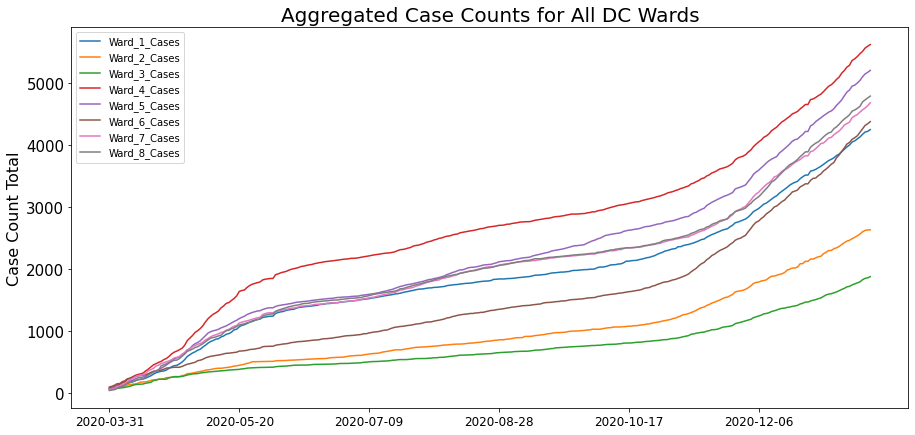

In [39]:
# The slopes for aggregated daily cases per Ward are highest from late April through May and also from November to
# mid-January. During the Summer months, the slopes flatten a bit. 
visualize_data(tot_cases_per_ward_df, ['Ward_1_Cases', 'Ward_2_Cases', 'Ward_3_Cases', 'Ward_4_Cases', 'Ward_5_Cases',
                                         'Ward_6_Cases', 'Ward_7_Cases', 'Ward_8_Cases'], 
               title='Aggregated Case Counts for All DC Wards', y_label='Case Count Total')

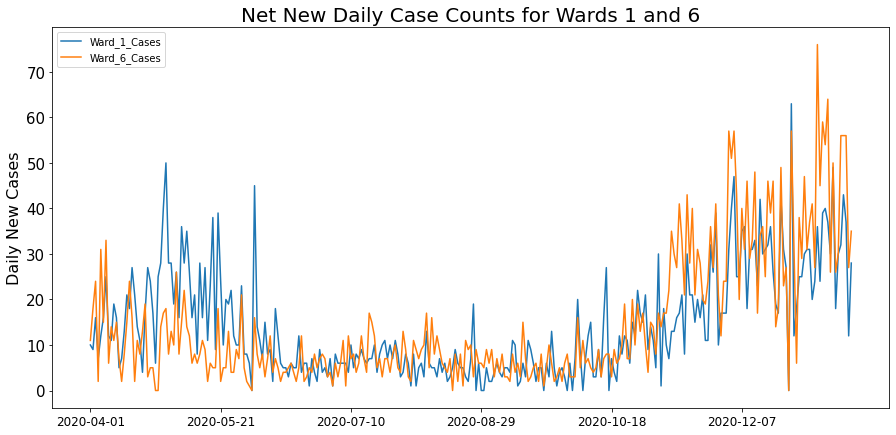

In [48]:
# Comparing Wards 1 and 6, net new daily cases spiked higher in Ward 1 during the first few months of the
# pandemic, whereas in the last few months, daily case counts have been higher in Ward 6. 
visualize_data(net_new_daily_cases, ['Ward_1_Cases', 'Ward_6_Cases'], 
               title='Net New Daily Case Counts for Wards 1 and 6', y_label='Daily New Cases')

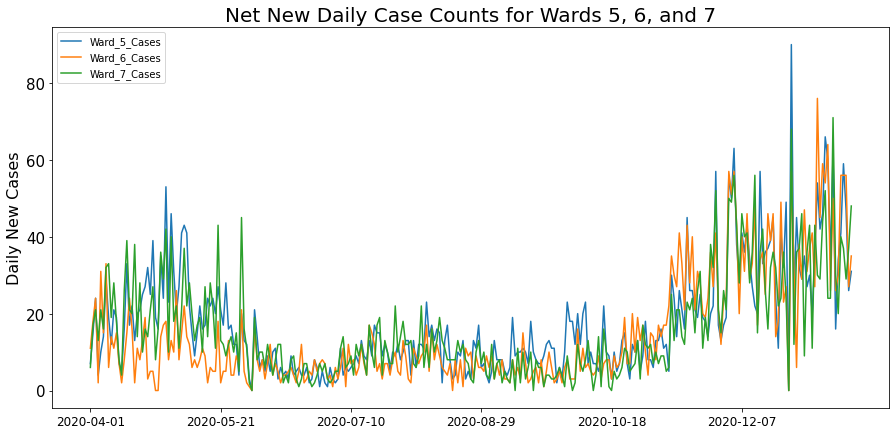

In [42]:
# The slopes for net new daily cases per Ward are highest from late April through May and also from November to
# mid-January. During the Summer months, the slopes flatten a bit.
visualize_data(net_new_daily_cases, ['Ward_5_Cases', 'Ward_6_Cases', 'Ward_7_Cases'], 
               title='Net New Daily Case Counts for Wards 5, 6, and 7', y_label='Daily New Cases')

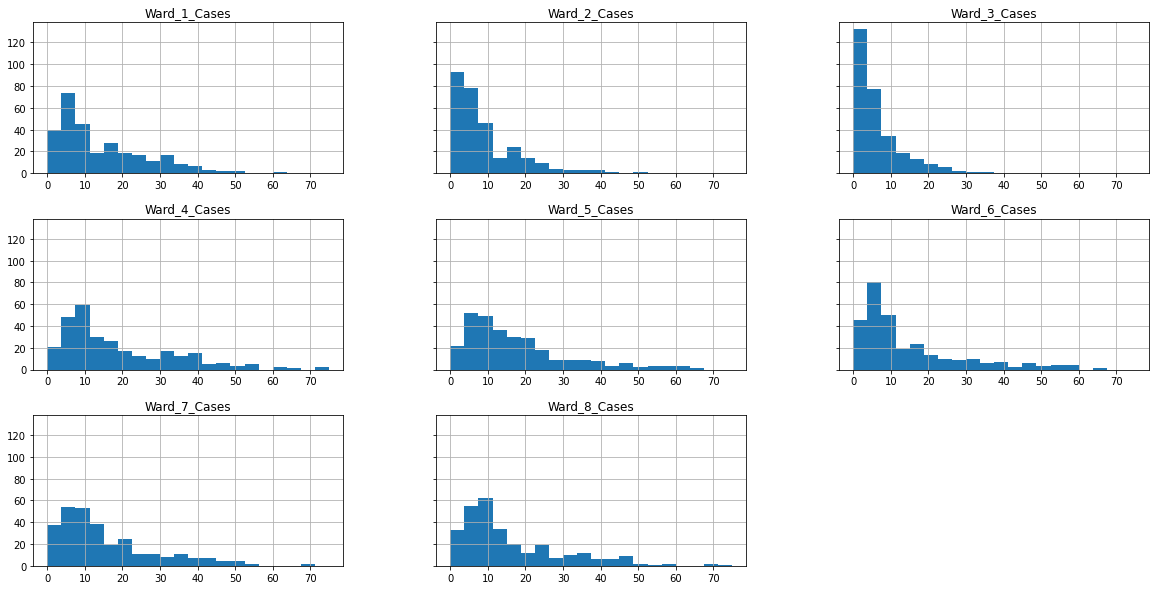

In [56]:
# Histograms outlining the frequency of net new daily positive cases documented for each Ward.
# Ward 3 has the most days in the lower 0-5 reported cases range, while other Wards have more varied distributions. 
# In Ward 4 for instance, about 30-41 cases were reported in one day on almost 20 occasions.

net_new_daily_cases.hist(figsize=(20, 10), range =[0, 75], bins=20, sharey=True);

In [51]:
# This function takes a list of Wards and returns time series line graph subplots for those wards' aggregated and net new
# daily reported Covid cases.
def covid_cases_agg_and_diff(ward_list):
        
    if len(ward_list) == 1:
        
        plt.figure(figsize=(18, 4))
        
        plt.subplot(121)
        plt.plot(tot_cases_per_ward_df[f'Ward_{str(ward_list[0])}_Cases'], label = 'test')
        plt.ylim(0, 4000)
        
        plt.subplot(122)
        plt.plot(tot_cases_per_ward_df[f'Ward_{str(ward_list[0])}_Cases'].diff(), label = 'test diff')
        plt.ylim(-20, 80)
        
    else:
        
        # Changing the size of the subplots depending on how many Wards are entered into the function
        if len(ward_list) <= 4:
            fig, axes = plt.subplots(nrows = len(ward_list), ncols = 2, figsize = (18, 9))
        else:
            fig, axes = plt.subplots(nrows = len(ward_list), ncols = 2, figsize = (18, 9))
        
        # Iterating through colors when plotting to differentiate multiple Wards
        colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey']

        for i in range(len(ward_list)):

            axes[i,0].plot(tot_cases_per_ward_df[f'Ward_{str(ward_list[i])}_Cases'], c=colors[i])
            axes[i,1].plot(tot_cases_per_ward_df[f'Ward_{str(ward_list[i])}_Cases'].diff(), c=colors[i])
            axes[i,0].set_title(f'Aggregate Positive Covid Cases in Ward {str(ward_list[i])}', size=20)
            axes[i,1].set_title(f'Net New Daily Positive Covid Cases in Ward {str(ward_list[i])}', size=20)
            axes[i,0].set_ylim([0, 6000])
            axes[i,1].set_ylim([0, 90])

        plt.tight_layout();

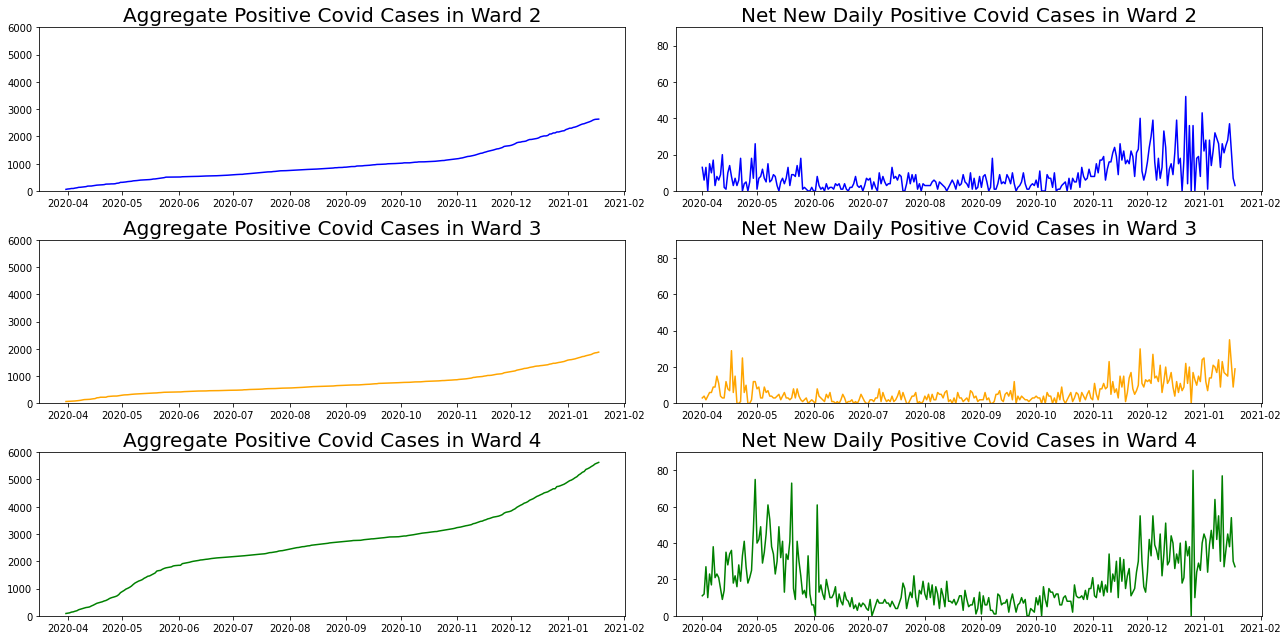

In [55]:
covid_cases_agg_and_diff([2, 3, 4])

In [ ]:
# rcParams

In [ ]:
def plot_seasonal_decompose(df, col):
    rcParams['figure.figsize'] = 12, 7
    rcParams['font.size'] = 14.0
    decomp = seasonal_decompose(df[col])
    decomp.plot();

In [ ]:
# Generating a decomposition plot
# Not a long enough time span to calculate seasonality
# From the residual graph, one can see large spikes in daily reported cases 
# during April to mid-May as well as mid-November to mid-January
# rcParams taken from https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3

plot_seasonal_decompose(net_new_daily_cases, 'Ward_4_Cases')

In [ ]:
# Generating a decomposition plot.
# Not a long enough time span to calculate seasonality.
# From the trend and residual graphs, one can see spikes during similar times when Ward 4 cases spiked,
# but the quantity is substantially lower (peak of 20 cases in Jan vs peak of 50 in Jan).
# rcParams taken from https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3

plot_seasonal_decompose(net_new_daily_cases, 'Ward_3_Cases')

In [ ]:
# 52-week  Autocorr and Partial Autocorr
def plot_acf_and_pacf(df, col):
    
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(121)
    fig = plot_acf(df[col], lags=60, ax=ax1, title = f'Autocorrelation for {col}')
    ax2 = fig.add_subplot(122)
    fig = plot_pacf(df[col], lags=60, ax=ax2, title = f'Partial Autocorrelation for {col}')

In [ ]:
visualize_data(net_new_daily_cases, ['Ward_2_Cases'], 
               title='Net New Daily Case Counts for Ward 2', y_label='Daily New Cases')

In [ ]:
plot_acf_and_pacf(net_new_daily_cases, 'Ward_2_Cases')

In [ ]:
for col in net_new_daily_cases.columns:
    plot_acf_and_pacf(net_new_daily_cases, col)

In [ ]:
# for col in net_new_daily_cases.columns:
#     plot_acf_and_pacf(net_new_daily_cases, col)

## Feature Engineering (Put in FE Notebook)

In [ ]:
# Loading and cleaning DC Ward statistics on population, proportion of black residents, poverty, unemployment, and income
# ward_stats = pd.read_csv('./Data/Ward_from_2012.csv')
# ward_stats = ward_stats[['LABEL', 'POP_2011_2015', 'POP_BLACK', 'PCT_BELOW_POV', 'UNEMPLOYMENT_RATE', 'PER_CAPITA_INCOME']]
# ward_stats.rename(columns={'POP_2011_2015':'TOTAL_POP'}, inplace=True)
# ward_stats.set_index('LABEL', inplace=True)
# ward_stats.sort_index(inplace=True)
# ward_stats

In [ ]:
# ward_populations = {}
# i = 0
# while i < 8:
#     ward_populations.update({ward_stats.index[i].replace(" ", "_") : ward_stats['TOTAL_POP'][i]})
#     i += 1

# for i, j in ward_populations.items():
#     tot_cases_per_ward_df[f'{i}_Case_Pct_Pop'] = tot_cases_per_ward_df[f'{i}_Cases'] / j
    
# tot_cases_per_ward_df.head()

In [ ]:
# visualize_data(tot_cases_per_ward_df, ['Ward_1_Case_Pct_Pop', 'Ward_2_Case_Pct_Pop', 'Ward_3_Case_Pct_Pop'], 
#                'Daily Case Counts for Wards 1, 2, and 3')

In [ ]:
rolling_avg_cases_df = pd.DataFrame()

for i in range(1, 9):
    
    rolling_avg_cases_df[f'Ward_{i}_Cases'] = tot_cases_per_ward_df[f'Ward_{i}_Cases']
    
    rolling_avg_cases_df[f'Ward_{i}_Cases_Y_3D_Avg'] = tot_cases_per_ward_df[f'Ward_{i}_Cases'].rolling(3).mean()
    
    rolling_avg_cases_df[f'Ward_{i}_Cases_Y_1W_Avg'] = tot_cases_per_ward_df[f'Ward_{i}_Cases'].rolling(7).mean()
    
    rolling_avg_cases_df[f'Ward_{i}_Cases_Y_2W_Avg'] = tot_cases_per_ward_df[f'Ward_{i}_Cases'].rolling(14).mean()

In [ ]:
# Making two new columns per Ward of the case data shifted forward by 24 and 48 hours, respectively

shifted_cases_df = pd.DataFrame()

for i in range(1, 9):
    
    shifted_cases_df[f'Ward_{i}_Cases'] = tot_cases_per_ward_df[f'Ward_{i}_Cases']
    
    shifted_cases_df[f'Ward_{i}_Cases_Yesterday'] = tot_cases_per_ward_df[f'Ward_{i}_Cases'].shift()
    
    shifted_cases_df[f'Ward_{i}_Cases_1_Week'] = tot_cases_per_ward_df[f'Ward_{i}_Cases'].shift(7)
    
    shifted_cases_df[f'Ward_{i}_Cases_1_Month'] = tot_cases_per_ward_df[f'Ward_{i}_Cases'].shift(30)

In [ ]:
# visualize_data(shifted_cases_df, ['Ward_2_Cases', 'Ward_2_Cases_1_Week', 'Ward_2_Cases_1_Month'], 'Ward 2 Aggregated Cases vs Week/Month Ago')

## Modeling

#### Augmented Dickey Fuller Testing

In [ ]:
# Function infers whether data is stationary according to the p-value extracted from Augmented Dickey Fuller test

def get_p_value_adfuller(df, alpha=0.05):
    
    for col in df.columns:
        
        dftest = adfuller(df[col])
    
        if dftest[1] >= alpha:
            print(f'The p-value for {col} is {dftest[1]}, which is greater than alpha {alpha}. Infer that the data is not stationary.')
           
        else:
            print(f'The p-value for {col} is {dftest[1]}, which is smaller than alpha {alpha}. Infer that the data is stationary.')

In [ ]:
get_p_value_adfuller(tot_cases_per_ward_df)

In [ ]:
get_p_value_adfuller(tot_cases_per_ward_df.diff().dropna())

In [ ]:
get_p_value_adfuller(tot_cases_per_ward_df.diff().diff().dropna())

In [ ]:
get_p_value_adfuller(tot_cases_per_ward_df[['Ward_8_Cases', 'Ward_8_Case_Pct_Pop']].diff().diff().diff().dropna())

In [ ]:
for i in range(1, 8):
    
    tot_cases_per_ward_df[f'Ward_{str(i)}_Cases_Diff_2'] = tot_cases_per_ward_df[f'Ward_{str(i)}_Cases'].diff().diff()
    
    tot_cases_per_ward_df[f'Ward_{str(i)}_Case_Pct_Pop_Diff_2'] = tot_cases_per_ward_df[f'Ward_{str(i)}_Case_Pct_Pop'].diff().diff()
    
tot_cases_per_ward_df['Ward_8_Cases_Diff_3'] = tot_cases_per_ward_df['Ward_8_Cases'].diff().diff().diff()
tot_cases_per_ward_df['Ward_8_Case_Pct_Pop_Diff_3'] = tot_cases_per_ward_df['Ward_8_Case_Pct_Pop'].diff().diff().diff()

In [ ]:
tot_cases_per_ward_df.columns

#### VAR Model

In [ ]:
# model_columns = ['Ward_1_Cases_Diff_2', 'Ward_1_Case_Pct_Pop_Diff_2', 'Ward_2_Cases_Diff_2', 'Ward_2_Case_Pct_Pop_Diff_2', 
#                  'Ward_3_Cases_Diff_2', 'Ward_3_Case_Pct_Pop_Diff_2', 'Ward_4_Cases_Diff_2', 'Ward_4_Case_Pct_Pop_Diff_2', 
#                  'Ward_5_Cases_Diff_2', 'Ward_5_Case_Pct_Pop_Diff_2', 'Ward_6_Cases_Diff_2', 'Ward_6_Case_Pct_Pop_Diff_2', 
#                  'Ward_7_Cases_Diff_2', 'Ward_7_Case_Pct_Pop_Diff_2', 'Ward_8_Cases_Diff_3', 'Ward_8_Case_Pct_Pop_Diff_3']

# model_columns = ['Ward_1_Cases_Diff_2', 'Ward_2_Cases_Diff_2', 
#                  'Ward_3_Cases_Diff_2', 'Ward_4_Cases_Diff_2', 
#                  'Ward_5_Cases_Diff_2', 'Ward_6_Cases_Diff_2', 
#                  'Ward_7_Cases_Diff_2', 'Ward_8_Cases_Diff_3']

model_columns = ['Ward_5_Cases_Diff_2', 'Ward_6_Cases_Diff_2', 'Ward_7_Cases_Diff_2']

# model_columns = ['Ward_1_Case_Pct_Pop_Diff_2', 'Ward_2_Case_Pct_Pop_Diff_2', 
#                  'Ward_3_Case_Pct_Pop_Diff_2', 'Ward_4_Case_Pct_Pop_Diff_2', 
#                  'Ward_5_Case_Pct_Pop_Diff_2', 'Ward_6_Case_Pct_Pop_Diff_2', 
#                  'Ward_7_Case_Pct_Pop_Diff_2', 'Ward_8_Case_Pct_Pop_Diff_3']

model_df = tot_cases_per_ward_df[model_columns].dropna()

In [ ]:
train, test = train_test_split(model_df, shuffle=False)

In [ ]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

In [ ]:
train_test_plot(train, test)

Establish a baseline model - persistence (naive), any others?

In [ ]:
fitted_model.plot()
plt.tight_layout()

In [ ]:
# Autoregressive model order
fitted_model.k_ar

In [ ]:
# Plotting the forecast looking one week ahead.
fitted_model.plot_forecast(7)
plt.tight_layout();

In [ ]:
# Generating a forecast one step ahead
fitted_model.forecast(train.values, 1)

In [ ]:
# Generating a forecast five steps ahead
fitted_model.forecast(train.values, 5)

In [ ]:
# Generating a forecast that matches testing set.
# fitted_model.forecast(train.values, len(test))

In [ ]:
# See the values of our test set.
# test.values

In [ ]:
# Save forecasted values
forecast = fitted_model.forecast(train.values, len(test))

In [ ]:
test.values[0]

In [ ]:
forecast[0]

In [ ]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

In [ ]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

How can I include shift/rolling/pct_pop columns in VAR model without predicting the values of those columns (exogenous?)

You can make 8 different ARIMA models for each Ward and have the other Wards be exogenous variables. 